In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import correlate2d
from sklearn.metrics import roc_curve, auc
from scipy.ndimage import rotate
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from keras.layers import Input, Dense, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D, concatenate
from keras.models import Model
import keras.backend as K
from tensorflow.keras.models import load_model
import seaborn as sns

2024-05-26 09:56:05.707154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 09:56:06.699835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    # output = Dense(n_classes, activation = 'softmax')(x)
    output = Dense(n_classes, activation='sigmoid')(x)  # Change for binary classification

    model = Model(input, output)
    return model

In [3]:
# defines the architecture of a DenseNet-121 model
input_shape = 64, 64, 1
n_classes = 1
model = densenet(input_shape,n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['max_pooling2d[0][0]']          
 alization)                                                                                   

In [4]:
layers = model.layers
print(f"The model has {len(layers)} layers")

The model has 423 layers


In [5]:
print(f"The input shape {model.input}")
print(f"The output shape {model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")


In [4]:
# compile in Keras is used to configure the learning process of a model before training. It prepares the model for training by specifying three important components
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

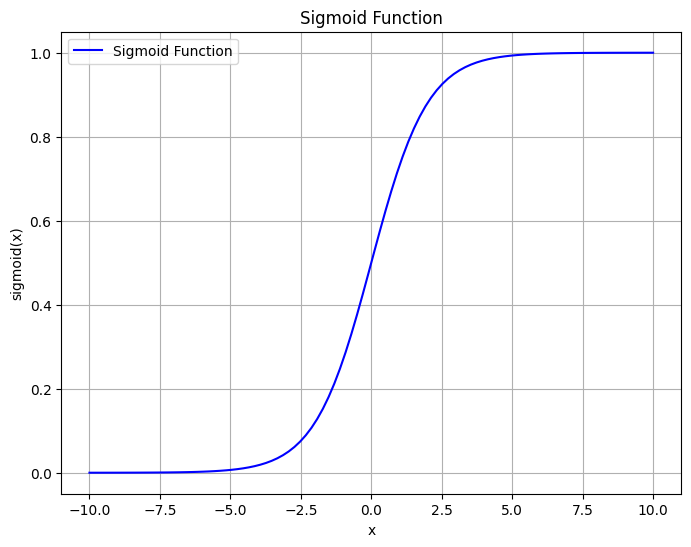

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Generate x values
x = np.linspace(-10, 10, 100)

# Compute y values using the sigmoid function
y = sigmoid(x)

# Plot the sigmoid function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Sigmoid Function', color='blue')
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.grid(True)
plt.legend()
plt.savefig('sigmoid function.jpg', format='jpg')
plt.show()


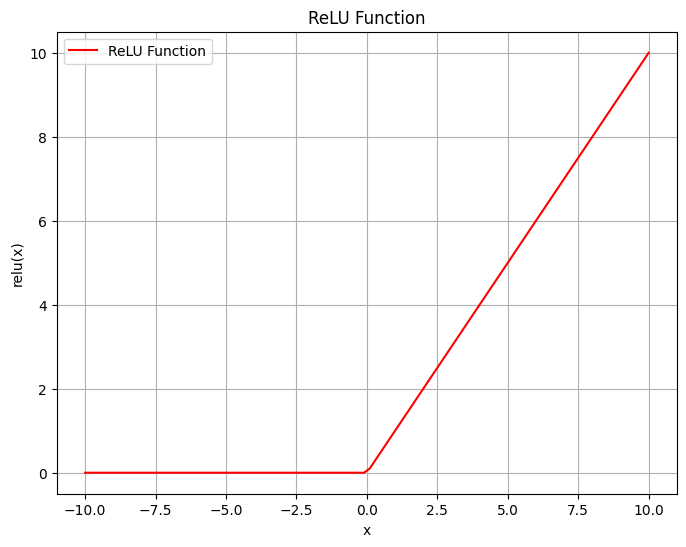

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ReLU function
def relu(x):
    return np.maximum(0, x)

# Generate x values
x = np.linspace(-10, 10, 100)

# Compute y values using the ReLU function
y = relu(x)

# Plot the ReLU function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='ReLU Function', color='red')
plt.title('ReLU Function')
plt.xlabel('x')
plt.ylabel('relu(x)')
plt.grid(True)
plt.legend()
plt.savefig('relu_function.jpg', format='jpg')
plt.show()


In [6]:
filepath = '/home/ngsci/project/template2.jpg'
templateImg = Image.open(filepath)
templateImg_array = np.array(templateImg)

# Filter the wanted part
templateImg_condition = ((templateImg_array[:,:,0] > 115) & (templateImg_array[:,:,2] < 200))
templateImg_filtered = np.zeros_like(templateImg_array)
templateImg_filtered[templateImg_condition] = templateImg_array[templateImg_condition]

# Convert the filtered image to grayscale
templateImg_gray = templateImg_filtered[:,:,0] * 0.6 + templateImg_filtered[:,:,1] * 0.3 + templateImg_filtered[:,:,2] * 0.1
#templateImg_gray_inverted = templateImg_gray
templateImg_gray_45 = rotate(templateImg_gray, 45, reshape=False)
templateImg_gray_90 = rotate(templateImg_gray, 90, reshape=False)
templateImg_gray_135 = rotate(templateImg_gray, -45, reshape=False)

In [7]:
def prepare_data(image_paths, prediction_values):
    images = []
    targets = []
    
    for image_path, prediction_value in zip(image_paths, prediction_values):
        image = load_image(image_path)
        image_array = np.array(image)  # Convert 'Image' object to NumPy array
        images.append(image_array)
        targets.append(prediction_value)
        
    # Convert lists to Numpy arrays
    images = np.array(images)
    targets = np.array(targets)
    return images, targets

def load_image(image_path):
    image = Image.open(image_path)
    
    tb_image = np.array(image)

    # Define the condition for TB pixels
    tb_condition = ((tb_image[:,:,0] > 130) & (tb_image[:,:,2] < 180)) # need to be same with template?

    # Set pixels that do not meet the condition to black (0,0,0)
    tb_image[~tb_condition] = [0, 0, 0]
    # change to gray scale
    tb_image_gray = 0.3*tb_image[:,:,0] + 0.6*tb_image[:,:,1] + 0.1*tb_image[:,:,2]

    # Assuming target_img and template_img are 2D arrays (grayscale images)
    ncc_result = correlate2d(tb_image_gray, templateImg_gray, mode='valid')
    ncc_result_45 = correlate2d(tb_image_gray, templateImg_gray_45, mode='valid')
    ncc_result_90 = correlate2d(tb_image_gray, templateImg_gray_90, mode='valid')
    ncc_result_135 = correlate2d(tb_image_gray, templateImg_gray_135, mode='valid')

    match_region = getMatchRegion(ncc_result, tb_image_gray)
    match_region_45 = getMatchRegion(ncc_result_45, tb_image_gray)
    match_region_90 = getMatchRegion(ncc_result_90, tb_image_gray)
    match_region_135 = getMatchRegion(ncc_result_135, tb_image_gray)
    
    height = width = 32
    # Create a new array for the combined image
    combined_image = np.zeros((height*2, width*2), dtype=np.uint8)

    # Place each image at the corresponding position
    combined_image[:height, :width] = match_region
    combined_image[:height, width:] = match_region_45
    combined_image[height:, :width] = match_region_90
    combined_image[height:, width:] = match_region_135

    # Convert the combined array back to an image
    combined_image = Image.fromarray(combined_image)

    return combined_image

def getMatchRegion(ncc_result, tb_image_gray):
    max_idx = np.argmax(ncc_result)

    # Convert index to row and column (subscript indices)
    best_row_ncc, best_col_ncc = np.unravel_index(max_idx, ncc_result.shape)

    tH, tW = templateImg_gray.shape[:2]
    match_region = tb_image_gray[best_row_ncc : best_row_ncc+tH, best_col_ncc : best_col_ncc+tW]
    
    return match_region

In [34]:
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
prediction_values = tb_label['tb_positive'][:400]
images_paths = tb_label['file_path'][:400]

input_data, target_data = prepare_data(images_paths, prediction_values)
history = model.fit(input_data, target_data, epochs=32, batch_size=50) # epochs: the number of iterations over the entire dataset; batch_size: number of samples used in each training iteration

Epoch 1/32
8/8 [==============================] - 38s 491ms/step - loss: 1.5984 - accuracy: 0.7875
Epoch 2/32
8/8 [==============================] - 4s 476ms/step - loss: 0.5251 - accuracy: 0.8675
Epoch 3/32
8/8 [==============================] - 4s 474ms/step - loss: 0.5139 - accuracy: 0.8575
Epoch 4/32
8/8 [==============================] - 4s 471ms/step - loss: 0.3922 - accuracy: 0.8650
Epoch 5/32
8/8 [==============================] - 4s 475ms/step - loss: 0.5354 - accuracy: 0.8675
Epoch 6/32
8/8 [==============================] - 4s 471ms/step - loss: 0.5191 - accuracy: 0.8575
Epoch 7/32
8/8 [==============================] - 4s 472ms/step - loss: 0.3846 - accuracy: 0.8675
Epoch 8/32
8/8 [==============================] - 4s 471ms/step - loss: 0.3878 - accuracy: 0.8675
Epoch 9/32
8/8 [==============================] - 4s 472ms/step - loss: 0.3841 - accuracy: 0.8675
Epoch 10/32
8/8 [==============================] - 4s 469ms/step - loss: 0.3836 - accuracy: 0.8625
Epoch 11/32
8/8 [=

Text(0.5, 1.0, 'Accuracy Evolution')

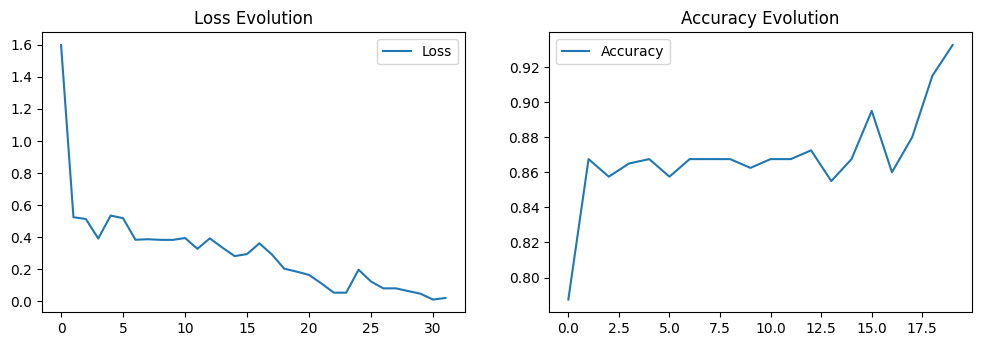

In [27]:
loss = [1.5984, 0.5251, 0.5139, 0.3922, 0.5354, 0.5191, 0.3846, 0.3878, 0.3841, 0.3836, 0.3955, 0.3282, 0.3932, 0.3365, 0.2827, 0.2953, 0.3623, 0.2932, 0.2043, 0.1860,
        0.1656, 0.1124, 0.0549, 0.0545, 0.1979, 0.1243, 0.0815, 0.0818, 0.0649, 0.0482, 0.0119, 0.0216]

accuracy = [0.7875, 0.8675, 0.8575, 0.8650, 0.8675, 0.8575, 0.8675, 0.8675, 0.8675, 0.8625, 0.8675, 0.8675, 0.8725, 0.8550, 0.8675, 0.8950, 0.8600, 0.8800, 
            0.9150, 0.9325]

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(loss, label='Loss')
#plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(accuracy, label='Accuracy')
#plt.plot(history.history['val_accuracy'], label='Val_Accuracy')  # Uncomment this line
plt.legend()
plt.title('Accuracy Evolution')


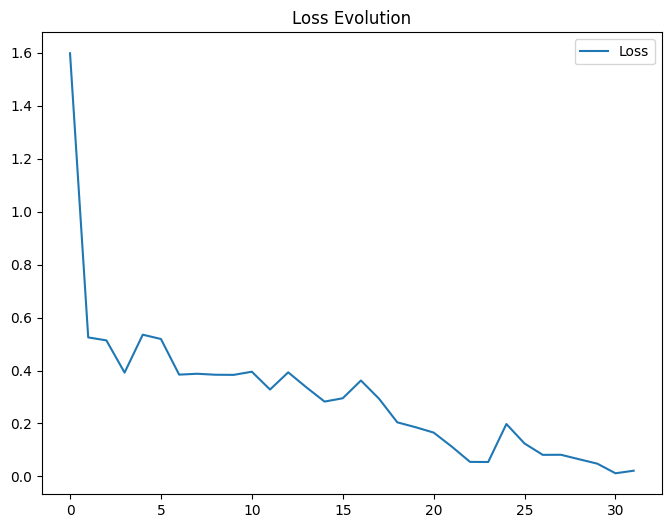

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Loss')
plt.legend()
plt.title('Loss Evolution')
plt.savefig('Loss Evolution 1.jpg', format='jpg')
plt.show()

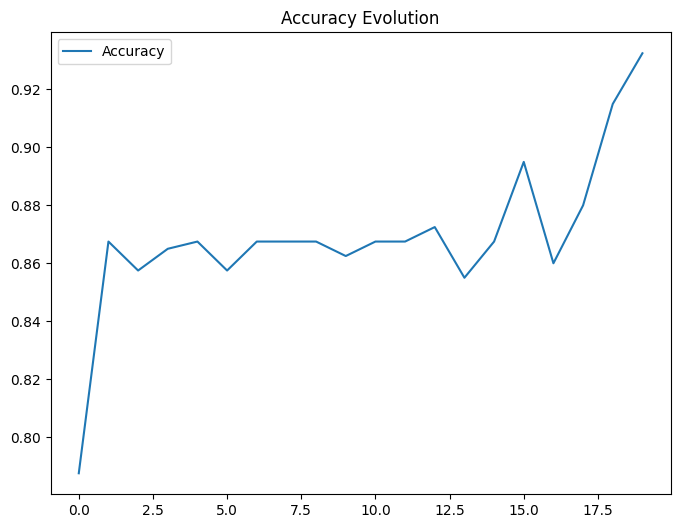

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.savefig('Accuracy Evolution 1.jpg', format='jpg')
plt.show()

In [45]:
# Save weights
model.save_weights('testModel400_weights.h5') # the model using the data in the first fold
# Save entire model
model.save('testmodel400.h5') # the model using the data in the first fold

In [9]:
# Step 1: Load the previously trained model
model = load_model('testmodel1000.h5')

# Step 2: Prepare the additional data
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
prediction_values_continue = tb_label['tb_positive'][1001:1500]
images_paths_continue = tb_label['file_path'][1001:1500]

new_input_data, new_target_data = prepare_data(images_paths_continue, prediction_values_continue)

# Step 3: Continue training
history = model.fit(new_input_data, new_target_data, epochs=16, batch_size=100, verbose=1)

Epoch 1/16
5/5 [==============================] - 25s 847ms/step - loss: 0.2180 - accuracy: 0.9459
Epoch 2/16
5/5 [==============================] - 4s 831ms/step - loss: 0.2041 - accuracy: 0.9459
Epoch 3/16
5/5 [==============================] - 4s 819ms/step - loss: 0.2063 - accuracy: 0.9459
Epoch 4/16
5/5 [==============================] - 4s 822ms/step - loss: 0.2006 - accuracy: 0.9459
Epoch 5/16
5/5 [==============================] - 4s 826ms/step - loss: 0.1964 - accuracy: 0.9459
Epoch 6/16
5/5 [==============================] - 4s 821ms/step - loss: 0.1926 - accuracy: 0.9459
Epoch 7/16
5/5 [==============================] - 4s 816ms/step - loss: 0.1930 - accuracy: 0.9459
Epoch 8/16
5/5 [==============================] - 4s 798ms/step - loss: 0.1922 - accuracy: 0.9459
Epoch 9/16
5/5 [==============================] - 4s 807ms/step - loss: 0.1839 - accuracy: 0.9459
Epoch 10/16
5/5 [==============================] - 4s 804ms/step - loss: 0.1720 - accuracy: 0.9459
Epoch 11/16
5/5 [=

In [10]:
# Save weights
model.save_weights('testModel1500_weights.h5') # the model using the data in the first fold
# Save entire model
model.save('testmodel1500.h5') # the model using the data in the first fold

Text(0.5, 1.0, 'Accuracy Evolution')

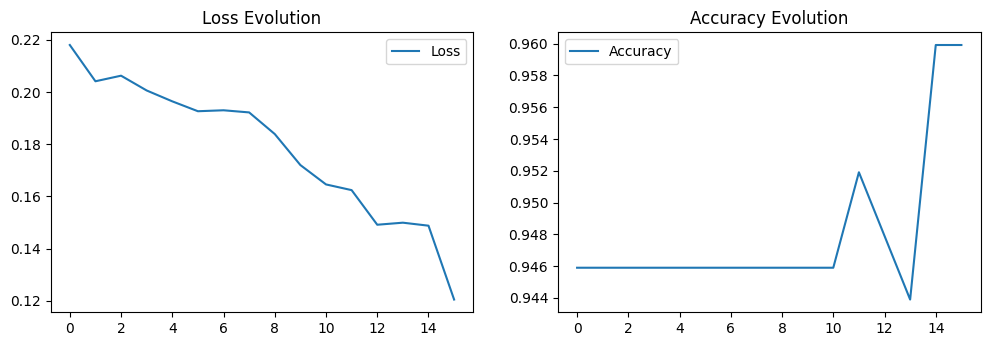

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
#plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
#plt.plot(history.history['val_accuracy'], label='Val_Accuracy')  # Uncomment this line
plt.legend()
plt.title('Accuracy Evolution')


In [30]:
loss = [0.218, 0.2041, 0.2063, 0.2006, 0.1964, 0.1926, 0.1930, 0.1922, 0.1839, 0.172, 0.1646, 0.1624, 0.1491, 0.1499, 0.1487, 0.1204]

accuracy = [0.9459, 0.9459, 0.9459, 0.9459, 0.9459, 0.9459, 0.9459, 0.9459, 0.9459, 0.9459, 0.9459, 0.9519, 0.9479, 0.9439, 0.9599, 0.9599]

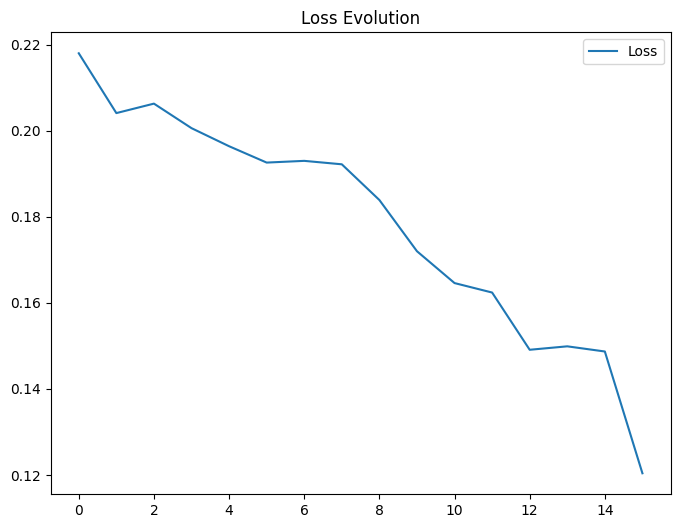

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Loss')
plt.legend()
plt.title('Loss Evolution')
plt.savefig('Loss Evolution 2.jpg', format='jpg')
plt.show()

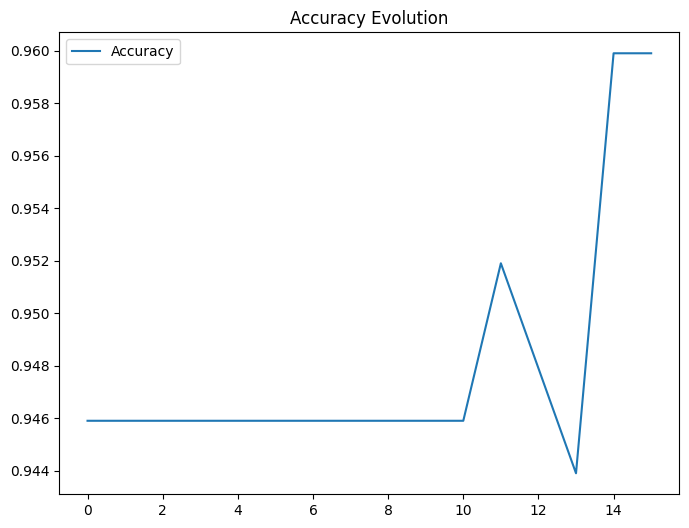

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.savefig('Accuracy Evolution 2.jpg', format='jpg')
plt.show()

In [20]:
# Step 1: Load the previously trained model
model = load_model('testmodel1500.h5')

# Step 2: Prepare the additional data
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
prediction_values_continue = tb_label['tb_positive'][1501:2000]
images_paths_continue = tb_label['file_path'][1501:2000]

new_input_data, new_target_data = prepare_data(images_paths_continue, prediction_values_continue)

# Step 3: Continue training
history = model.fit(new_input_data, new_target_data, epochs=16, batch_size=100, verbose=1)

Epoch 1/16
5/5 [==============================] - 26s 798ms/step - loss: 0.3076 - accuracy: 0.9078
Epoch 2/16
5/5 [==============================] - 4s 794ms/step - loss: 0.2510 - accuracy: 0.9218
Epoch 3/16
5/5 [==============================] - 4s 793ms/step - loss: 0.2949 - accuracy: 0.9218
Epoch 4/16
5/5 [==============================] - 4s 791ms/step - loss: 0.2353 - accuracy: 0.9259
Epoch 5/16
5/5 [==============================] - 4s 790ms/step - loss: 0.2358 - accuracy: 0.9259
Epoch 6/16
5/5 [==============================] - 4s 793ms/step - loss: 0.2182 - accuracy: 0.9259
Epoch 7/16
5/5 [==============================] - 4s 789ms/step - loss: 0.2033 - accuracy: 0.9259
Epoch 8/16
5/5 [==============================] - 4s 787ms/step - loss: 0.1774 - accuracy: 0.9299
Epoch 9/16
5/5 [==============================] - 4s 799ms/step - loss: 0.1528 - accuracy: 0.9399
Epoch 10/16
5/5 [==============================] - 4s 796ms/step - loss: 0.1563 - accuracy: 0.9479
Epoch 11/16
5/5 [=

In [21]:
# Save weights
model.save_weights('testModel2000_weights.h5') # the model using the data in the first fold
# Save entire model
model.save('testmodel2000.h5') # the model using the data in the first fold

Text(0.5, 1.0, 'Accuracy Evolution')

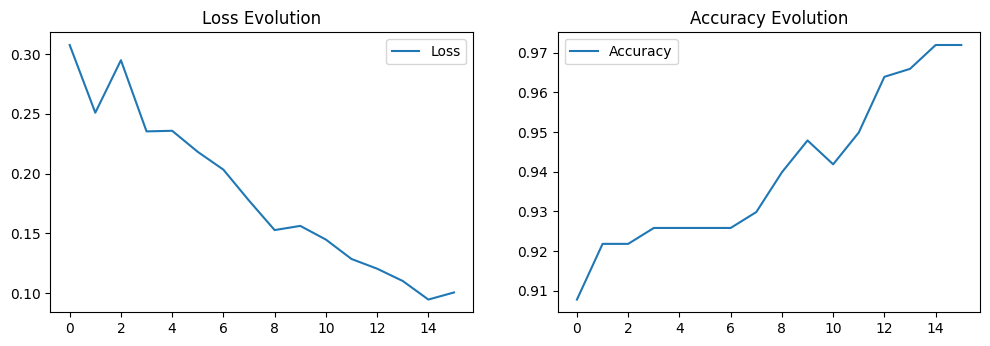

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
#plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
#plt.plot(history.history['val_accuracy'], label='Val_Accuracy')  # Uncomment this line
plt.legend()
plt.title('Accuracy Evolution')


In [33]:
loss = [0.3076, 0.2510, 0.2949, 0.2353, 0.2358, 0.2182, 0.2033, 0.1774, 0.1528, 0.1563, 0.1448, 0.1286, 0.1205, 0.1102, 0.0946, 0.1006]

accuracy = [0.9078, 0.9218, 0.9218, 0.9259, 0.9259, 0.9259, 0.9259, 0.9299, 0.9399, 0.9479, 0.9419, 0.9499, 0.9639, 0.9659, 0.9719, 0.9719]

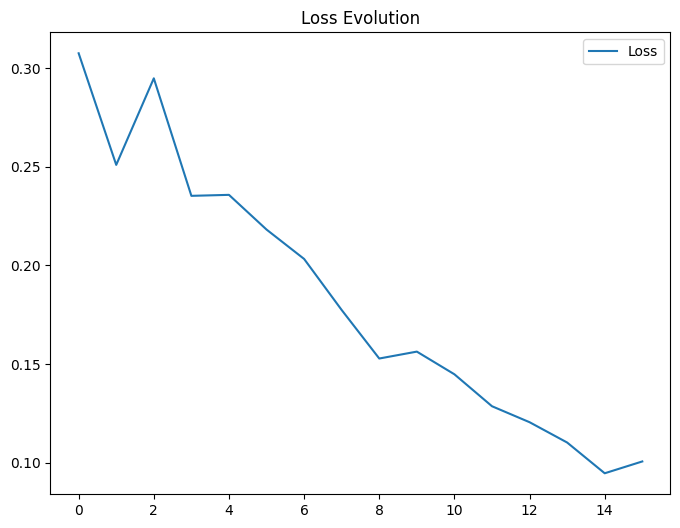

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Loss')
plt.legend()
plt.title('Loss Evolution')
plt.savefig('Loss Evolution 3.jpg', format='jpg')
plt.show()

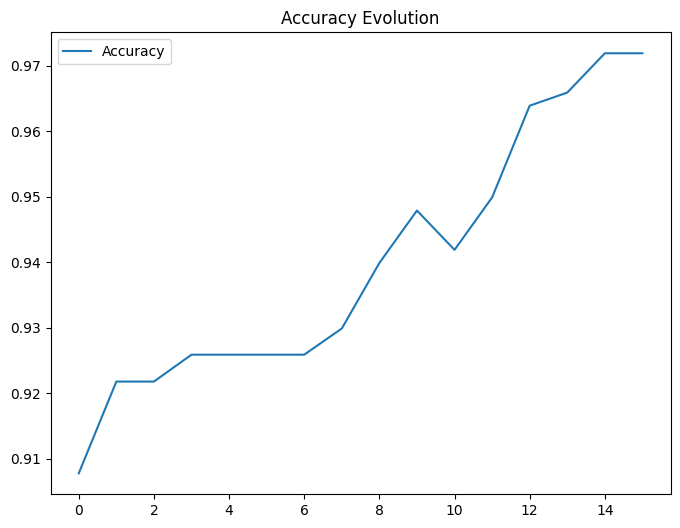

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.savefig('Accuracy Evolution 3.jpg', format='jpg')
plt.show()

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val))


In [5]:
# Load entire model
loaded_model = load_model('testmodel2000.h5')

In [6]:
def predictedValue(images_paths):
    test_images = prepare_image(images_paths)

    # Expand dimensions of test_images
    test_images_expanded = np.expand_dims(test_images, axis=0)

    # Predict values for each test image
    predicted_values = []
    for i in range(len(test_images)):
        #predicted_value = loaded_model.predict(np.expand_dims(test_images[i], axis=0))
        predicted_value = loaded_model.predict(np.expand_dims(test_images[i], axis=0))
        predicted_values.append(predicted_value)
    
    return predicted_values

def getPredictedValue(predictedValue):
    # Concatenate predicted values along axis 0
    predicted_values = np.concatenate(predictedValue, axis=0)
    
    return predictedValue

def prepare_image(image_paths):
    images = []
    
    for image_path in (image_paths):
        image = load_image(image_path)
        image_array = np.array(image)  # Convert 'Image' object to NumPy array
        images.append(image_array)
        
    # Convert lists to Numpy arrays
    images = np.array(images)
    return images

def adjustPrediction(predicted_values, threshold):
    # Set the threshold to normalize the result
    predicted_values = np.array(predicted_values)

    predicted_labels = np.where(predicted_values > threshold, 1, 0)
    return predicted_labels

def calculate_metrics(ground_truth, predictions):
    true_positive = sum((ground_truth == 1) & (predictions == 1))
    true_negative = sum((ground_truth == 0) & (predictions == 0))
    false_positive = sum((ground_truth == 0) & (predictions == 1))
    false_negative = sum((ground_truth == 1) & (predictions == 0))

    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)

    return sensitivity, specificity

def draw_roc_curve(ground_truth, predictions):
    fpr, tpr, _ = roc_curve(ground_truth, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
filepath = '/home/ngsci/project/template2.jpg'
templateImg = Image.open(filepath)
templateImg_array = np.array(templateImg)

# Filter the wanted part
templateImg_condition = ((templateImg_array[:,:,0] > 115) & (templateImg_array[:,:,2] < 200))
templateImg_filtered = np.zeros_like(templateImg_array)
templateImg_filtered[templateImg_condition] = templateImg_array[templateImg_condition]

# Convert the filtered image to grayscale
templateImg_gray = templateImg_filtered[:,:,0] * 0.6 + templateImg_filtered[:,:,1] * 0.3 + templateImg_filtered[:,:,2] * 0.1
#templateImg_gray_inverted = templateImg_gray
templateImg_gray_45 = rotate(templateImg_gray, 45, reshape=False)
templateImg_gray_90 = rotate(templateImg_gray, 90, reshape=False)
templateImg_gray_135 = rotate(templateImg_gray, -45, reshape=False)

In [16]:
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
verified_labels = tb_label['tb_positive'][2000:2500].values  # Ensure to convert to NumPy array or list
test_images_paths = tb_label['file_path'][2000:2500].tolist()  # Convert Series to list

predicted = predictedValue(test_images_paths)

1/1 [==============================] - 0s 31ms/step


In [47]:
import csv

file_name = "predicted_value.csv"

# Write the list to a CSV file
with open(file_name, "w", newline="") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(predicted)

print(f"CSV file '{file_name}' has been created successfully.")

CSV file 'predicted_value.csv' has been created successfully.


In [31]:
predicted = pd.read_csv('predicted_value.csv')
predicted

,[4.330271e-14]
0,[0.00014689]
1,[3.957985e-06]
2,[1.26514005e-05]
3,[1.1470913e-06]
4,[0.00244521]
...,...
494,[0.00691441]
495,[1.11433085e-10]
496,[0.00048145]
497,[0.00129498]


In [42]:
import pandas as pd
import numpy as np

# Load the CSV file
data = pd.read_csv('predicted_value.csv')

# Assuming the first column has no header name, you can access it by its index [0]
# If it has a name, replace '0' with the column name
first_column = data.iloc[:, 0]

# Remove brackets and convert to integers
test_values = np.array([float(value.strip('[]')) for value in first_column])

In [43]:
import numpy as np

# Assuming 'values' is the list you want to convert and sort
test_values = np.array(test_values)  # Convert 'values' list to a NumPy array
sorted_values = np.sort(test_values)  # Sort the NumPy array

In [44]:
index = int(0.9 * len(sorted_values)-1)

# Get the value at that index
threshold = sorted_values[index]
threshold

0.00443732

In [315]:
#predicted_values = getPredictedValue(predicted)
# Extracting values from the nested arrays
#extracted_values = [value[0] for value in predicted_values]

In [45]:
#threshold += 0.00001  # for binarizing the result
predicted_labels = adjustPrediction(test_values, threshold)

In [46]:
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
verified_labels = tb_label['tb_positive'][2001:2500].values

Sensitivity: 0.0
Specificity: 0.887719298245614


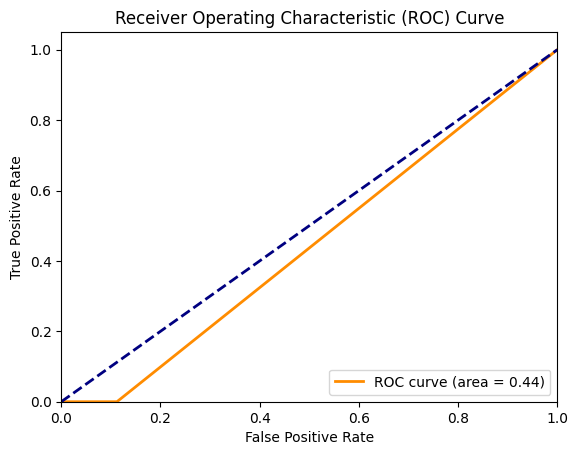

In [40]:
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
verified_labels = tb_label['tb_positive'][2001:2301].values
predicted_labels = predicted_labels[0:300]
predicted_labels = np.squeeze(predicted_labels)
sensitivity, specificity = calculate_metrics(verified_labels, predicted_labels)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
draw_roc_curve(verified_labels, predicted_labels)

Sensitivity: 0.0
Specificity: 1.0


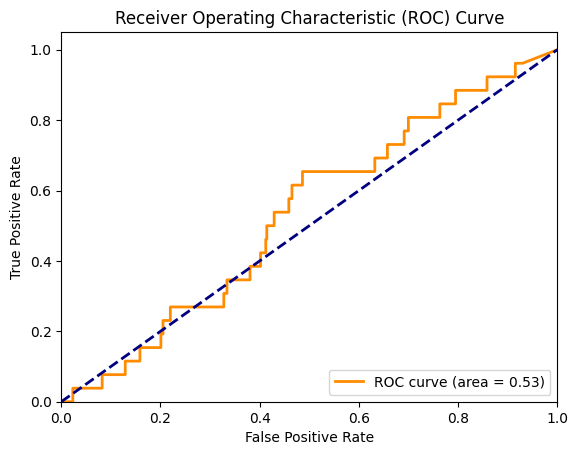

In [324]:
predicted_labels = np.squeeze(test_values)
sensitivity, specificity = calculate_metrics(verified_labels, predicted_labels)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
draw_roc_curve(verified_labels, predicted_labels)

In [328]:
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
prediction_values = tb_label['tb_positive'][0:2000]
prediction_values

0       0
1       0
2       0
3       0
4       1
       ..
1995    0
1996    0
1997    0
1998    0
1999    0
Name: tb_positive, Length: 2000, dtype: int64

In [329]:
# Count the number of occurrences of '1' in the prediction_values
count_1 = prediction_values[prediction_values == 1].count()

# Calculate the percentage of '1' values
percentage_1 = (count_1 / len(prediction_values)) * 100

# Print the results
print("Number of '1' values:", count_1)
print("Percentage of '1' values:", percentage_1)

Number of '1' values: 185
Percentage of '1' values: 9.25


In [13]:
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
verified_labels = tb_label['tb_positive'][2500:3000].values  # Ensure to convert to NumPy array or list
test_images_paths = tb_label['file_path'][2500:3000].tolist()  # Convert Series to list

predicted = predictedValue(test_images_paths)

1/1 [==============================] - 0s 33ms/step


In [50]:
import csv

file_name = "predicted_value2.csv"
column_name = "predicted_values"  # Define the column name

# Assuming 'predicted' is your list of predicted values
#predicted = [...]

# Write the list to a CSV file with the column name
with open(file_name, "w", newline="") as csvfile:
    csvwriter = csv.writer(csvfile)
    
    # Write the column name as the header
    csvwriter.writerow([column_name])
    
    # Write the predicted values
    csvwriter.writerows(predicted)

print(f"CSV file '{file_name}' has been created successfully.")


NameError: name 'predicted' is not defined

In [8]:
import pandas as pd
import numpy as np

# Load the CSV file
data = pd.read_csv('predicted_value2.csv')

# Assuming the first column has no header name, you can access it by its index [0]
# If it has a name, replace '0' with the column name
first_column = data.iloc[:, 0]

# Remove brackets and convert to integers
test_values = np.array([float(value.strip('[]')) for value in first_column])
test_values = test_values[0:100]
test_values

array([1.46824170e-05, 5.37476100e-13, 1.94894800e-05, 4.11321700e-34,
       2.54987040e-08, 5.33231850e-15, 2.25734000e-03, 1.58862000e-03,
       2.98798970e-11, 4.96470000e-04, 5.83650360e-33, 3.95458980e-07,
       7.07135650e-07, 0.00000000e+00, 1.34707640e-05, 1.68365400e-02,
       3.84310000e-04, 1.28657990e-15, 5.95759500e-05, 1.35840000e-04,
       0.00000000e+00, 1.25922020e-05, 1.58995190e-05, 5.32207960e-05,
       2.70977930e-05, 1.74151490e-09, 3.12362300e-20, 1.31648260e-07,
       1.39350000e-04, 3.18566200e-09, 7.82258400e-06, 1.55094530e-17,
       1.16201216e-17, 7.25479940e-07, 0.00000000e+00, 5.85500000e-04,
       0.00000000e+00, 8.79650000e-04, 4.77180000e-04, 0.00000000e+00,
       1.69061890e-27, 0.00000000e+00, 5.42940000e-04, 3.11722600e-02,
       2.13946340e-08, 2.57208900e-06, 9.55935800e-06, 2.00963170e-05,
       8.87662460e-05, 1.91847990e-07, 7.54581000e-03, 0.00000000e+00,
       7.61564930e-07, 3.31290000e-04, 9.59777200e-09, 4.33662000e-03,
      

In [9]:
import numpy as np

# Assuming 'values' is the list you want to convert and sort
test_values = np.array(test_values)  # Convert 'values' list to a NumPy array
sorted_values = np.sort(test_values)  # Sort the NumPy array
sorted_values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.11321700e-34, 5.83650360e-33, 1.69061890e-27,
       1.76055940e-23, 3.12362300e-20, 8.57450700e-20, 1.16201216e-17,
       1.55094530e-17, 1.28657990e-15, 5.33231850e-15, 2.39129770e-14,
       4.90622220e-14, 5.37476100e-13, 2.98798970e-11, 1.74151490e-09,
       3.18566200e-09, 3.50562560e-09, 6.99654650e-09, 9.59777200e-09,
       1.61177900e-08, 2.13946340e-08, 2.53999240e-08, 2.54987040e-08,
       5.47763700e-08, 7.04667760e-08, 9.01237340e-08, 1.31648260e-07,
       1.91847990e-07, 2.42346120e-07, 3.95458980e-07, 7.07135650e-07,
       7.25479940e-07, 7.61564930e-07, 7.90045700e-07, 2.57208900e-06,
       2.59081640e-06, 7.82258400e-06, 9.55935800e-06, 1.20430350e-05,
       1.25922020e-05, 1.34707640e-05, 1.46824170e-05, 1.58995190e-05,
       1.59783940e-05, 1.94894800e-05, 2.00963170e-05, 2.01491310e-05,
      

In [10]:
index = int(0.8 * len(sorted_values))

# Get the value at that index
threshold = sorted_values[index]
threshold

0.00054294

In [11]:
#threshold += 0.00001  # for binarizing the result
predicted_labels = adjustPrediction(test_values, threshold)
predicted_labels

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [12]:
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
verified_labels = tb_label['tb_positive'][2500:2600].values
verified_labels

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

Sensitivity: 0.5
Specificity: 0.8229166666666666


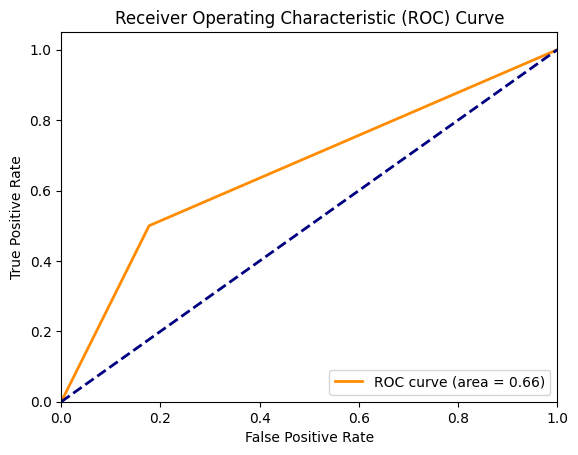

In [13]:
predicted_labels = np.squeeze(predicted_labels)
sensitivity, specificity = calculate_metrics(verified_labels, predicted_labels)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
draw_roc_curve(verified_labels, predicted_labels)

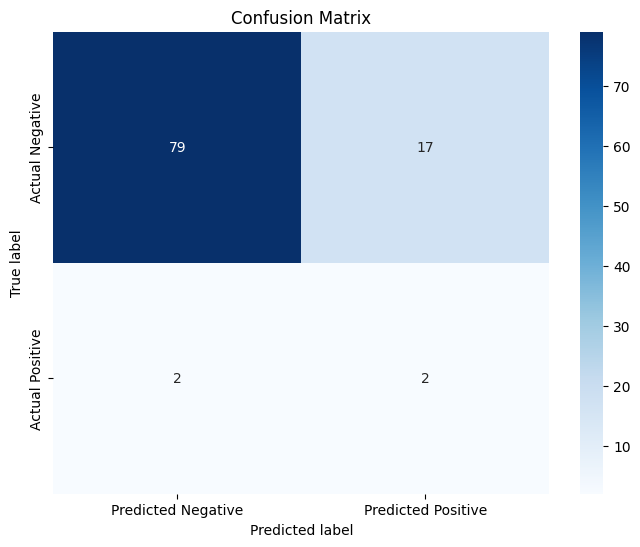

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(verified_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
# Save the plot as a JPG image
plt.savefig('confusion_matrix.jpg', format='jpg')
plt.show()

Sensitivity: nan
Specificity: 1.0


/tmp/ipykernel_215/386398425.py:47: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = true_positive / (true_positive + false_negative)


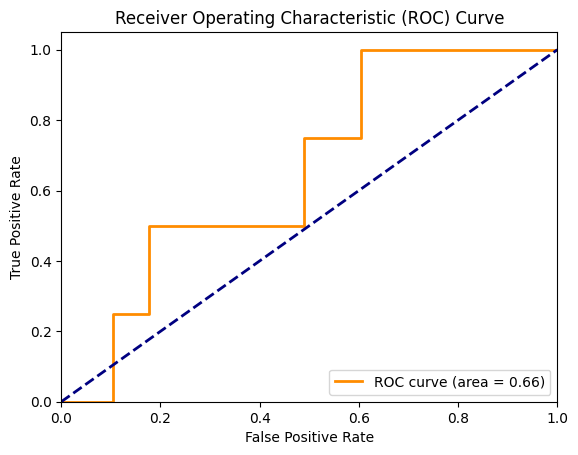

In [19]:
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
verified_labels = tb_label['tb_positive'][2500:2600].values
test_values = test_values[0:100]
predicted_labels = np.squeeze(test_values)
sensitivity, specificity = calculate_metrics(verified_labels, predicted_labels)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
draw_roc_curve(verified_labels, predicted_labels)

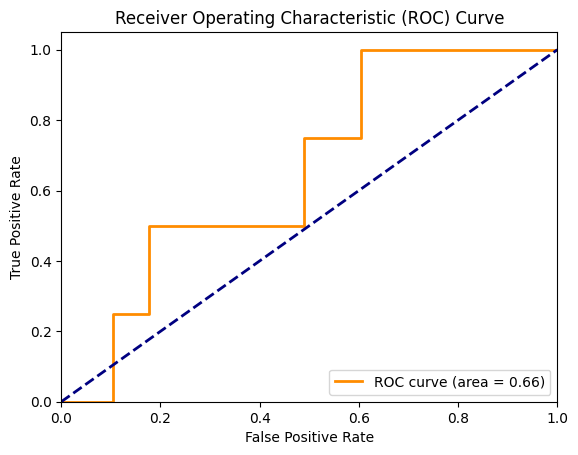

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
verified_labels = tb_label['tb_positive'][2500:2600].values
test_values = test_values[0:100]

# Assuming you have verified_labels and predicted_labels already defined
fpr, tpr, thresholds = roc_curve(verified_labels, test_values)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save the plot as a JPG image
plt.savefig('roc_curve.jpg', format='jpg')

# Show the plot
plt.show()


In [17]:
import pandas as pd
import numpy as np

# Load the CSV file
data = pd.read_csv('predicted_value2.csv')

# Assuming the first column has no header name, you can access it by its index [0]
# If it has a name, replace '0' with the column name
first_column = data.iloc[:, 0]

# Remove brackets and convert to integers
test_values = np.array([float(value.strip('[]')) for value in first_column])
test_values = test_values[0:100]

# Assuming 'values' is the list you want to convert and sort
test_values = np.array(test_values)  # Convert 'values' list to a NumPy array
sorted_values = np.sort(test_values)  # Sort the NumPy array
index = int(0.8 * len(sorted_values))

# Get the value at that index
threshold = sorted_values[index]
predicted_labels = adjustPrediction(test_values, threshold)
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
verified_labels = tb_label['tb_positive'][2500:2600].values
predicted_labels = np.squeeze(predicted_labels)
sensitivity, specificity = calculate_metrics(verified_labels, predicted_labels)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
test_values

Sensitivity: 0.5
Specificity: 0.8229166666666666


array([1.46824170e-05, 5.37476100e-13, 1.94894800e-05, 4.11321700e-34,
       2.54987040e-08, 5.33231850e-15, 2.25734000e-03, 1.58862000e-03,
       2.98798970e-11, 4.96470000e-04, 5.83650360e-33, 3.95458980e-07,
       7.07135650e-07, 0.00000000e+00, 1.34707640e-05, 1.68365400e-02,
       3.84310000e-04, 1.28657990e-15, 5.95759500e-05, 1.35840000e-04,
       0.00000000e+00, 1.25922020e-05, 1.58995190e-05, 5.32207960e-05,
       2.70977930e-05, 1.74151490e-09, 3.12362300e-20, 1.31648260e-07,
       1.39350000e-04, 3.18566200e-09, 7.82258400e-06, 1.55094530e-17,
       1.16201216e-17, 7.25479940e-07, 0.00000000e+00, 5.85500000e-04,
       0.00000000e+00, 8.79650000e-04, 4.77180000e-04, 0.00000000e+00,
       1.69061890e-27, 0.00000000e+00, 5.42940000e-04, 3.11722600e-02,
       2.13946340e-08, 2.57208900e-06, 9.55935800e-06, 2.00963170e-05,
       8.87662460e-05, 1.91847990e-07, 7.54581000e-03, 0.00000000e+00,
       7.61564930e-07, 3.31290000e-04, 9.59777200e-09, 4.33662000e-03,
      

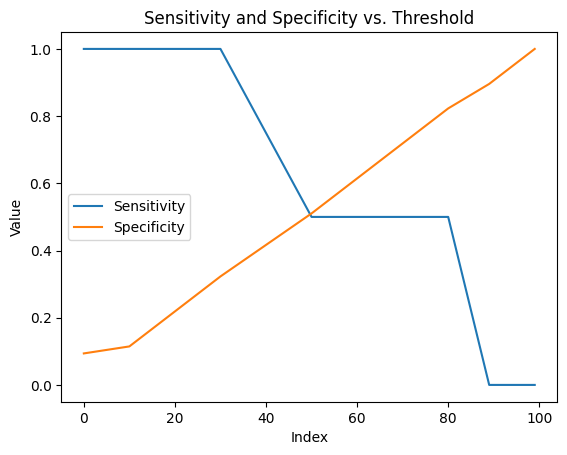

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calSS(index, sorted_values, test_values):
    threshold = sorted_values[index]
    predicted_labels = adjustPrediction(test_values, threshold)
    tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
    verified_labels = tb_label['tb_positive'][2500:2600].values
    predicted_labels = np.squeeze(predicted_labels)
    sensitivity, specificity = calculate_metrics(verified_labels, predicted_labels)
    return sensitivity, specificity

# Load the CSV file
data = pd.read_csv('predicted_value2.csv')

# Assuming the first column has no header name, you can access it by its index [0]
# If it has a name, replace '0' with the column name
first_column = data.iloc[:, 0]

# Remove brackets and convert to integers
test_values = np.array([float(value.strip('[]')) for value in first_column])
test_values = test_values[0:100]

# Assuming 'values' is the list you want to convert and sort
test_values = np.array(test_values)  # Convert 'values' list to a NumPy array
sorted_values = np.sort(test_values)  # Sort the NumPy array

senArr = []
speArr = []
indices = []  # Store indices for x-axis
i = 0
while i < 1:
    index = int(i * len(sorted_values))
    sensitivity, specificity = calSS(index, sorted_values, test_values)
    senArr.append(sensitivity)
    speArr.append(specificity)
    indices.append(index)  # Store index
    i += 0.1

# Plot sensitivity and specificity with indices as x-axis
plt.plot(indices, senArr, label='Sensitivity')
plt.plot(indices, speArr, label='Specificity')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Sensitivity and Specificity vs. Threshold')
plt.legend()
plt.savefig('Sensitivity_and_Specificity_vs_Threshold.jpg', format='jpg')
plt.show()

# Save results to CSV
results_df = pd.DataFrame({'Index': indices, 'Sensitivity': senArr, 'Specificity': speArr})
results_df.to_csv('sensitivity_specificity_results.csv', index=False)


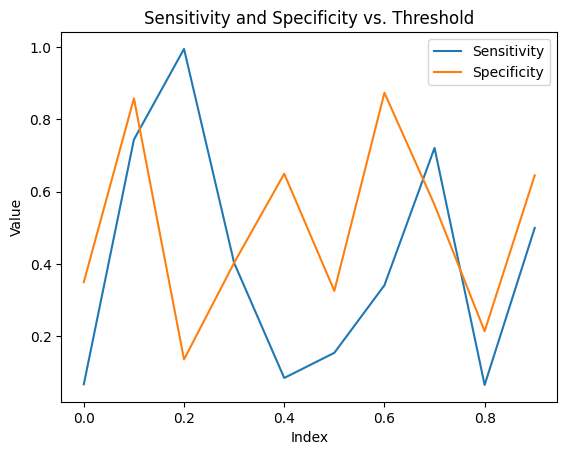

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate sensitivity and specificity
def calculate_metrics(verified_labels, predicted_labels):
    # Implementation of sensitivity and specificity calculation
    # Replace this with your actual implementation
    sensitivity = np.random.rand()
    specificity = np.random.rand()
    return sensitivity, specificity

# Load the CSV file
data = pd.read_csv('predicted_value2.csv')

# Assuming the first column has no header name, you can access it by its index [0]
# If it has a name, replace '0' with the column name
first_column = data.iloc[:, 0]

# Remove brackets and convert to integers
test_values = np.array([float(value.strip('[]')) for value in first_column])
test_values = test_values[0:100]

# Assuming 'values' is the list you want to convert and sort
test_values = np.array(test_values)  # Convert 'values' list to a NumPy array
sorted_values = np.sort(test_values)  # Sort the NumPy array

# Load verified labels
tb_label = pd.read_csv('/home/ngsci/datasets/tb-wellgen-smear/v1/tb-labels.csv')
verified_labels = tb_label['tb_positive'][2500:2600].values

# Initialize lists to store sensitivity and specificity values
sensitivity_values = []
specificity_values = []
indices = []

# Vary the index from 0 to len(sorted_values) with steps of 0.1
# Vary the index from 0 to len(sorted_values) with steps of 0.1
for i in np.arange(0.0, 1.0, 0.1):  # Corrected this line to use np.arange for float steps
    # Get the value at the current index
    index = int(i * (len(sorted_values) - 1))  # Corrected the index calculation
    threshold = sorted_values[index]
    predicted_labels = adjustPrediction(test_values, threshold)
    
    # Calculate sensitivity and specificity
    sensitivity, specificity = calculate_metrics(verified_labels, predicted_labels)
    
    # Append the values to the lists
    sensitivity_values.append(sensitivity)
    specificity_values.append(specificity)
    indices.append(i)

# Create DataFrame to store data
results_df = pd.DataFrame({
    'Index': indices,
    'Sensitivity': sensitivity_values,
    'Specificity': specificity_values
})

# Plot sensitivity and specificity
plt.plot(results_df['Index'], results_df['Sensitivity'], label='Sensitivity')
plt.plot(results_df['Index'], results_df['Specificity'], label='Specificity')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Sensitivity and Specificity vs. Threshold')
plt.legend()
plt.savefig('Sensitivity_and_Specificity_vs_Threshold.jpg', format='jpg')  # Corrected filename
plt.show()

# Save results to CSV
results_df.to_csv('sensitivity_specificity_results.csv', index=False)
